In [2]:
import sys
sys.path.append('..')

import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque

from lariat import Event

In [3]:
allclusters = pd.read_pickle("/Users/user/data/research/proton-deuteron/csv/allclusters.pkl"); print(allclusters.shape)
allclusters = allclusters[allclusters['column_maxes'].map(len) > 15].reset_index(drop=True); print(allclusters.shape)

(438575, 27)
(64032, 27)


In [4]:
masses = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/picky+match.csv')

In [5]:
maxes = allclusters['column_maxes'].values

In [6]:
normalised = []

for signal in maxes:
    minimum = np.min(signal)
    maximum = np.max(signal)

    if maximum > minimum:
        normalised_signal = (signal - minimum) / (maximum - minimum)
    else:
        normalised_signal = np.zeros_like(signal, dtype=float)
        print('Error: Max not greater than min in signal.')
    normalised.append(normalised_signal)

allclusters['normalised'] = normalised
adcdiff = [np.diff(signal) for signal in normalised]; allclusters['adcdiff'] = adcdiff
maxdiff = [np.max(diff) for diff in adcdiff]; allclusters['maxdiff'] = maxdiff

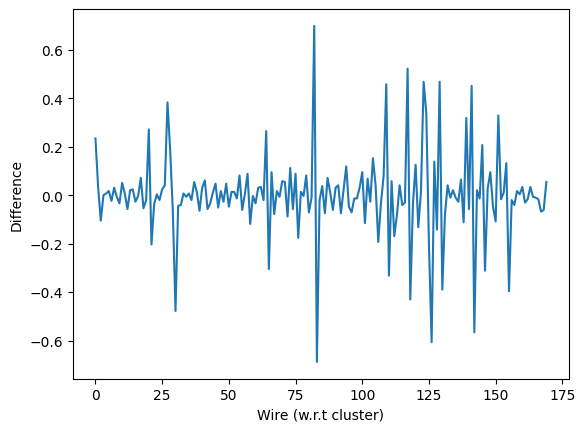

In [7]:
plt.plot(adcdiff[0]); plt.ylabel('Difference'); plt.xlabel('Wire (w.r.t cluster)')
plt.show()

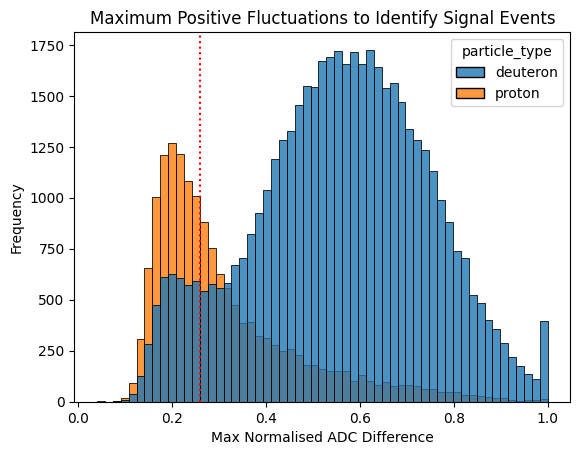

In [8]:
plt.figure()

sns.histplot(data=allclusters,
             x='maxdiff',
             hue='particle_type',
             bins='auto',
             alpha=0.8)

plt.axvline(0.26, color='red', linestyle=':' )

plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Frequency')
plt.title('Maximum Positive Fluctuations to Identify Signal Events')
plt.show()

Finding cleanest samples

In [9]:
cleanclusters = allclusters[allclusters['maxdiff'] <= 0.26].reset_index(drop=True)

In [10]:
cleanclusters = pd.merge(
    cleanclusters,
    masses[['run', 'subrun', 'event', 'beamline_mass']],
    on=['run', 'subrun', 'event'],
    how='left'
)

In [11]:
# overlap = []

print(cleanclusters.shape)

for idx, diff in enumerate(cleanclusters['adcdiff'].values):
    for i in range(5, len(diff) - 5):
        if diff[i] < -0.4:

            # cluster = cleanclusters['normalised'][idx]
            # signal = cluster[:i + 1]
            # noise = signal[i + 1:]

            # overlap.append({
            #     'index': idx,
            #     'split_point': i,
            #     'signal': signal,
            #     'noise': noise
            # })

            cleanclusters = cleanclusters.drop(idx)
            break

cleanclusters = cleanclusters.reset_index(drop=True); print(cleanclusters.shape)

# print(f"Found {len(overlap)} events with large negative decreases.")

(11948, 31)
(11788, 31)


In [12]:
deuterons = cleanclusters[(cleanclusters['particle_type'] == 'deuteron') & (cleanclusters['plane'] == 'collection')]
protons = cleanclusters[(cleanclusters['particle_type'] == 'proton') & (cleanclusters['plane'] == 'collection')]

In [13]:
deuteronscount = deuterons.drop_duplicates(subset=['run', 'subrun', 'event']).reset_index(drop=True)
protonscount = protons.drop_duplicates(subset=['run', 'subrun', 'event']).reset_index(drop=True)

In [14]:
deuteron_interest = cleanclusters[(cleanclusters['plane'] == 'collection') & (cleanclusters['height'] < 20) & (cleanclusters['particle_type'] == 'deuteron') & (cleanclusters['bbox_min_row'] < 120) & (cleanclusters['beamline_mass'] > 1750) & (cleanclusters['beamline_mass'] < 1950)]; print(len(deuteron_interest))
proton_interest = cleanclusters[(cleanclusters['plane'] == 'collection') & (cleanclusters['height'] > 30) & (cleanclusters['height'] < 50) & (cleanclusters['particle_type'] == 'proton')]; print(len(proton_interest))

12
1206


In [15]:
sumADC = [np.sum(cluster, axis=1)[:-1] for cluster in cleanclusters['image_intensity'].values]; cleanclusters['energy'] = sumADC
residual_range = [list(range(len(cluster)-1, -1, -1)) for cluster in cleanclusters['energy'].values]; cleanclusters['rr'] = residual_range

In [ ]:
# cleanclusters.to_pickle('/Users/user/data/research/proton-deuteron/csv/final.pkl')

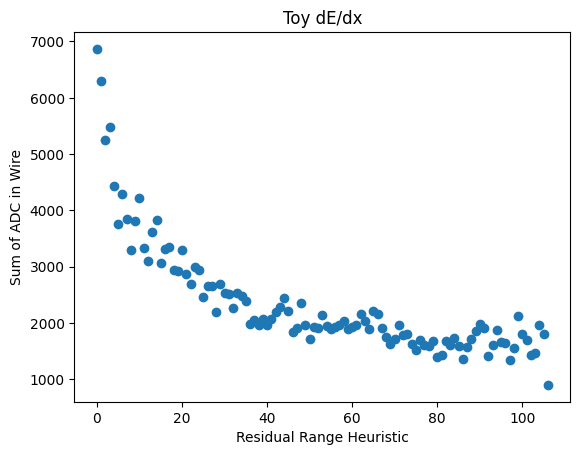

In [45]:
dedx = cleanclusters[['energy', 'rr']]
i=355
plt.scatter(dedx['rr'][i], dedx['energy'][i]); plt.ylabel('Sum of ADC in Wire'); plt.xlabel('Residual Range Heuristic'); plt.title('Toy dE/dx'); plt.show()

In [14]:
normalised_e = []
for energy in cleanclusters['energy']:
    minimum = np.min(energy)
    maximum = np.max(energy)

    if maximum > minimum:
        normalised = (energy - minimum) / (maximum - minimum)
    else:
        normalised = np.zeros_like(energy, dtype=float)

    normalised_e.append(normalised)

cleanclusters['normalised_e'] = normalised_e

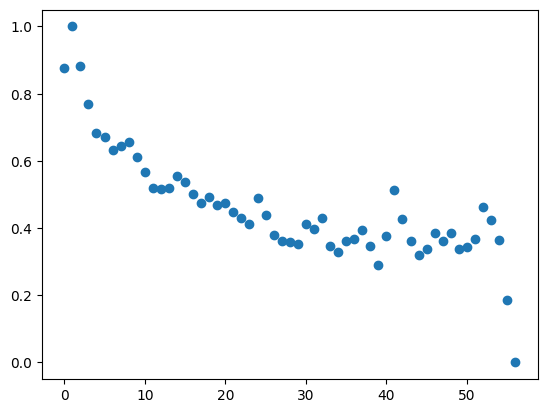

In [15]:
dedx = cleanclusters[['normalised_e', 'rr']]
i=675
plt.scatter(dedx['rr'][i], dedx['normalised_e'][i])

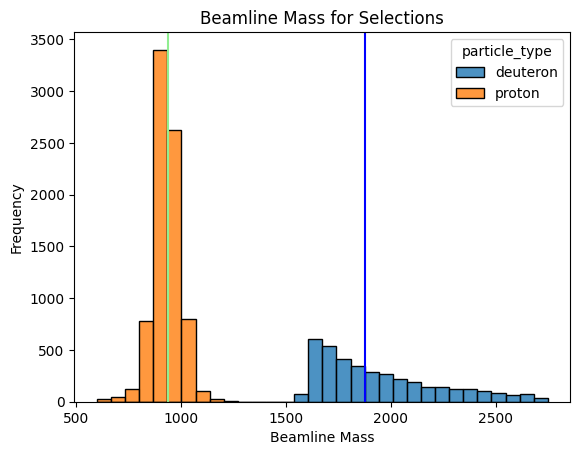

In [ ]:
plt.figure()

sns.histplot(data=cleanclusters,
             x='beamline_mass',
             hue='particle_type',
             bins='auto',
             alpha=0.8)

plt.axvline(938, color='lightgreen')
plt.axvline(1876, color='blue')

plt.xlabel('Beamline Mass')
plt.ylabel('Frequency')
plt.title('Beamline Mass for Selections')
plt.show()

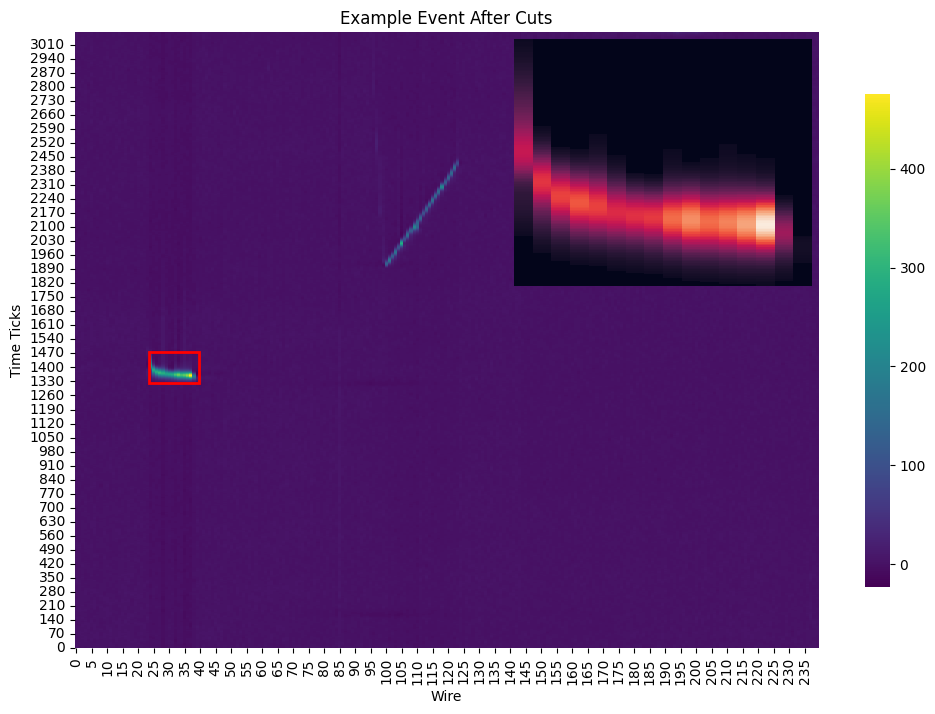

Event 0


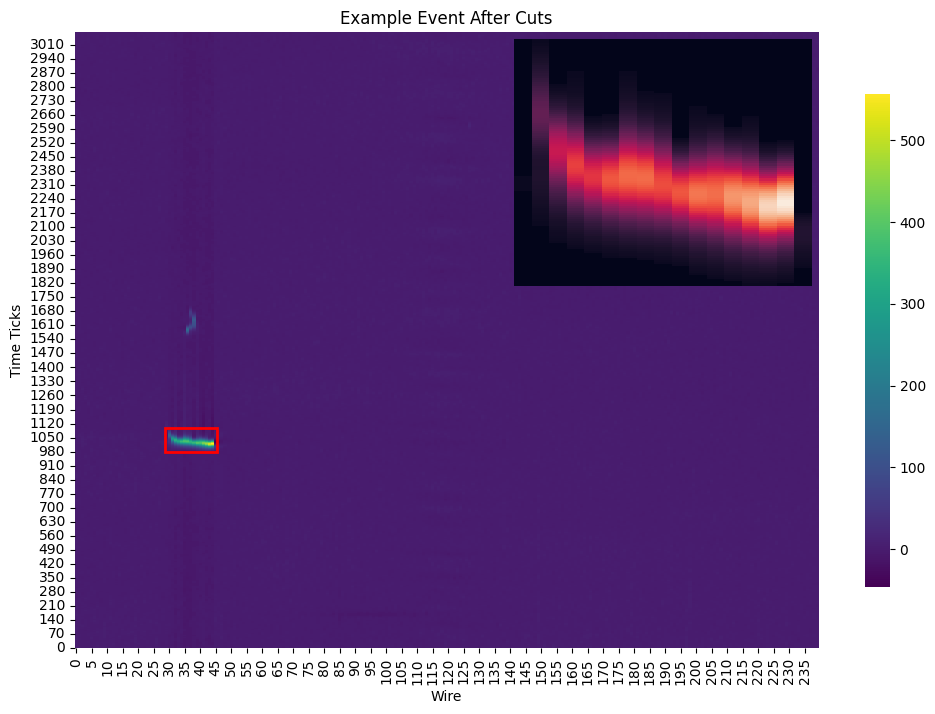

Event 1


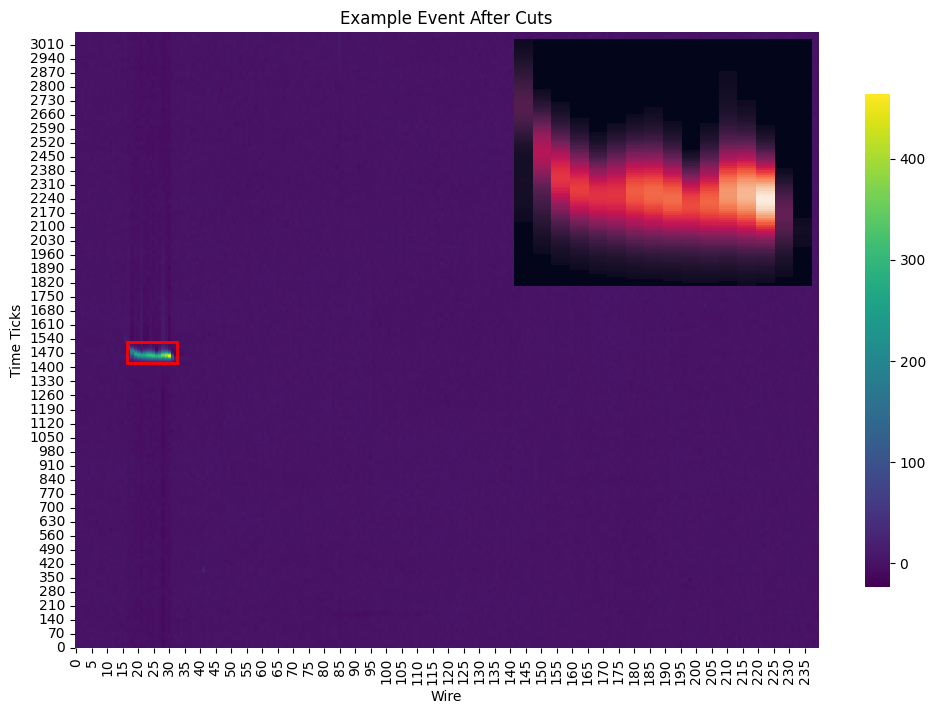

Event 2


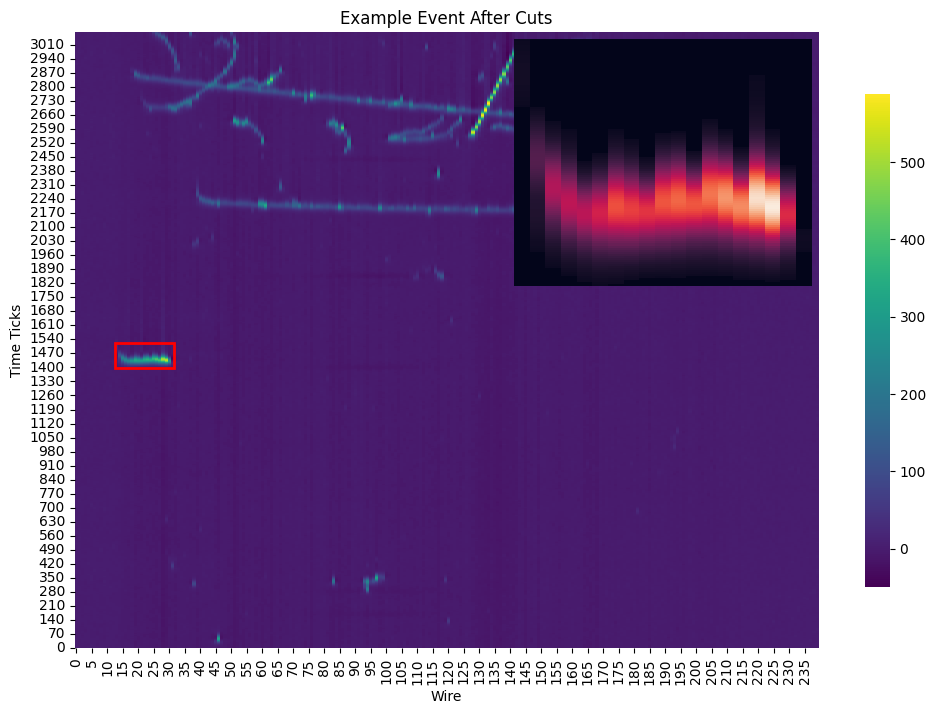

Event 3


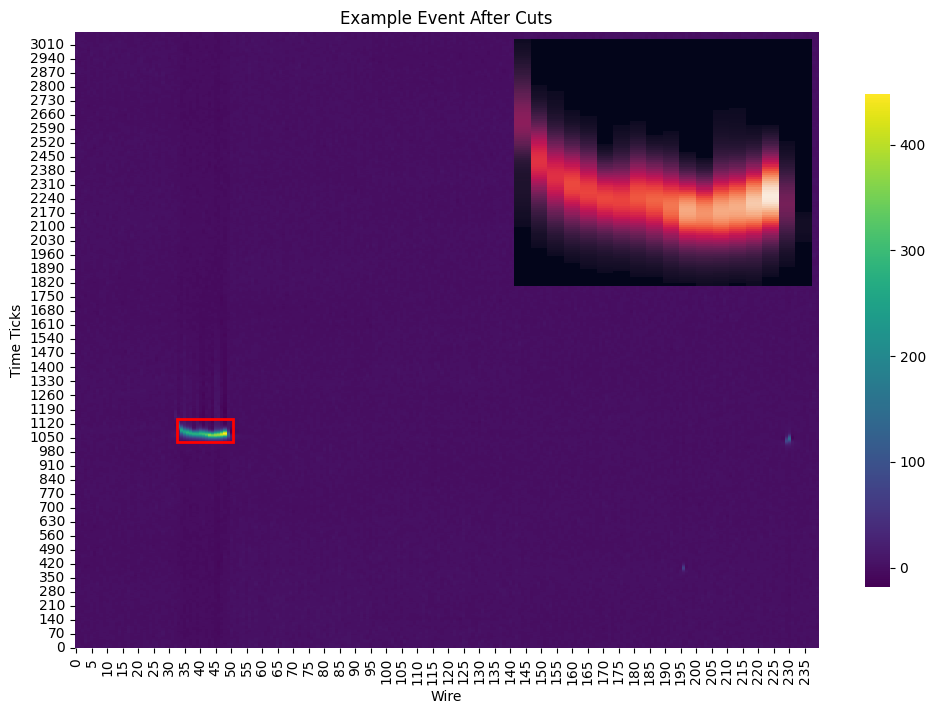

Event 4


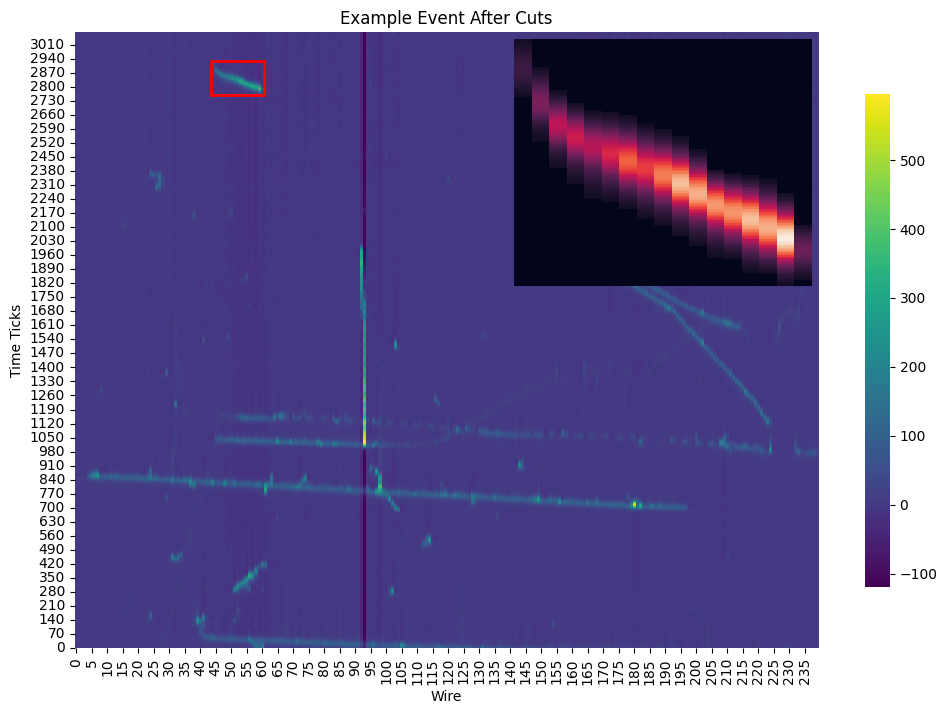

Event 5


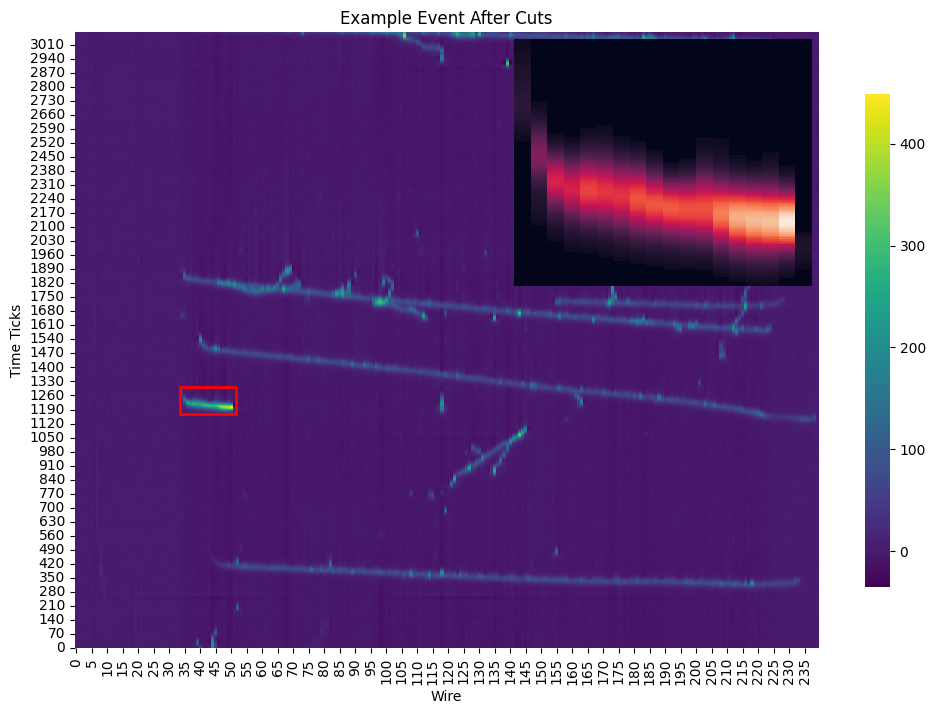

Event 6


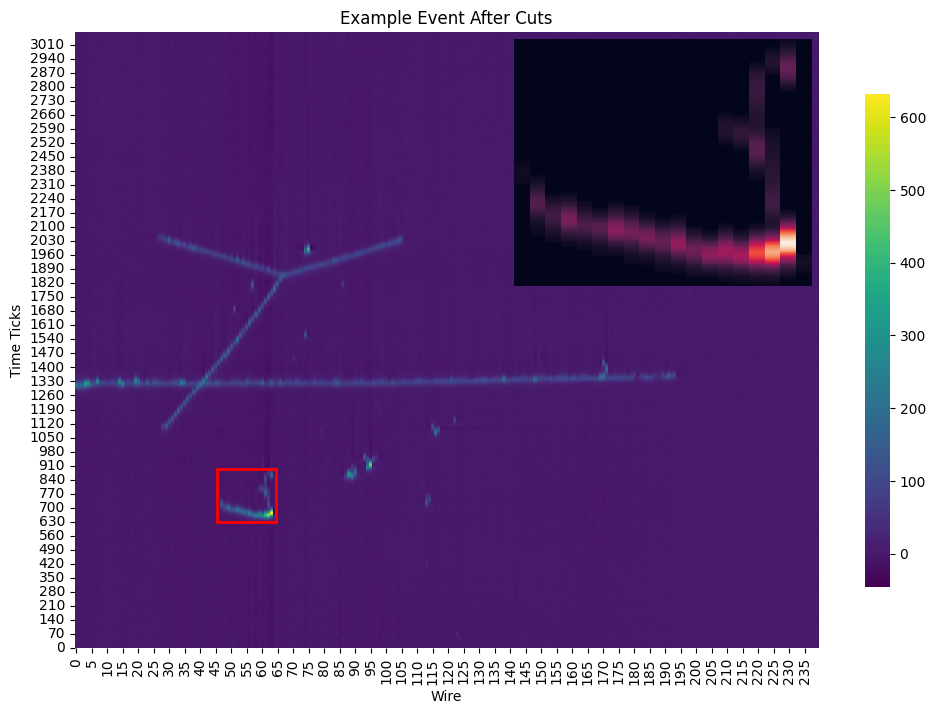

Event 7


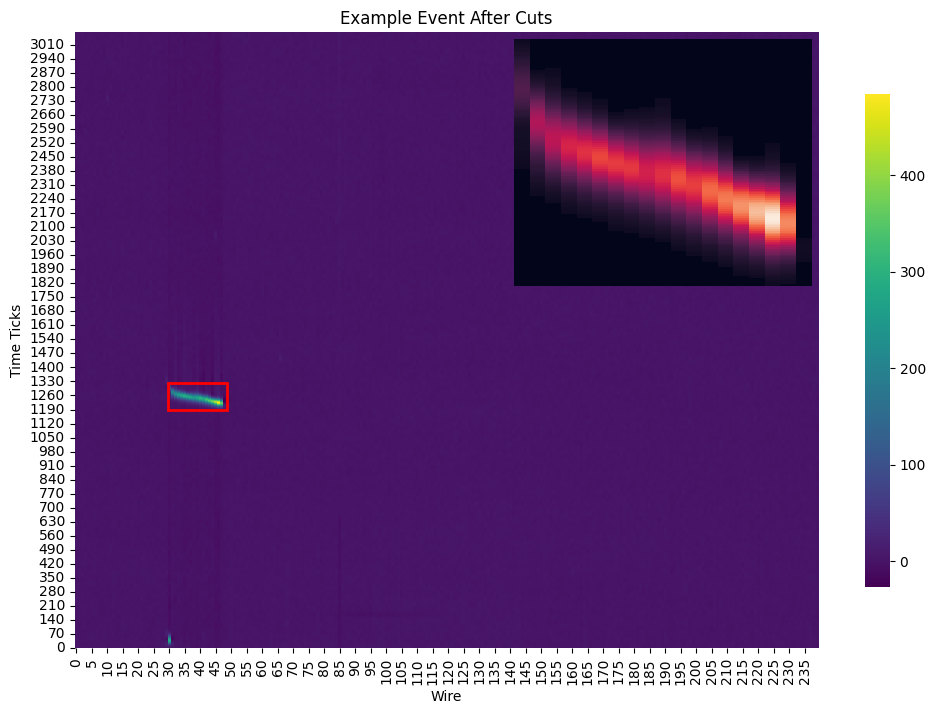

Event 8


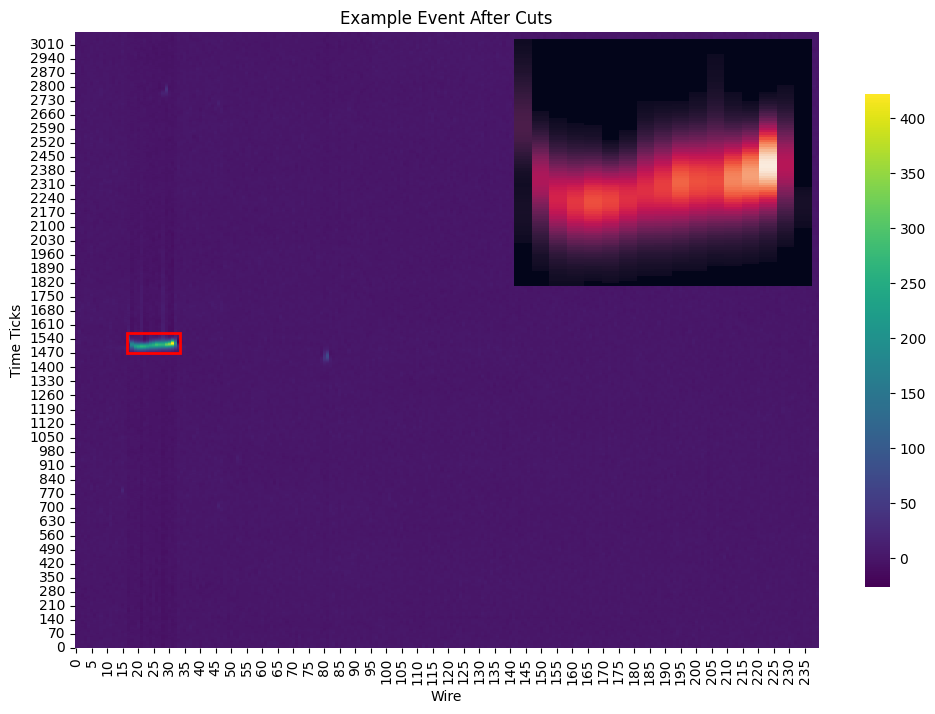

Event 9


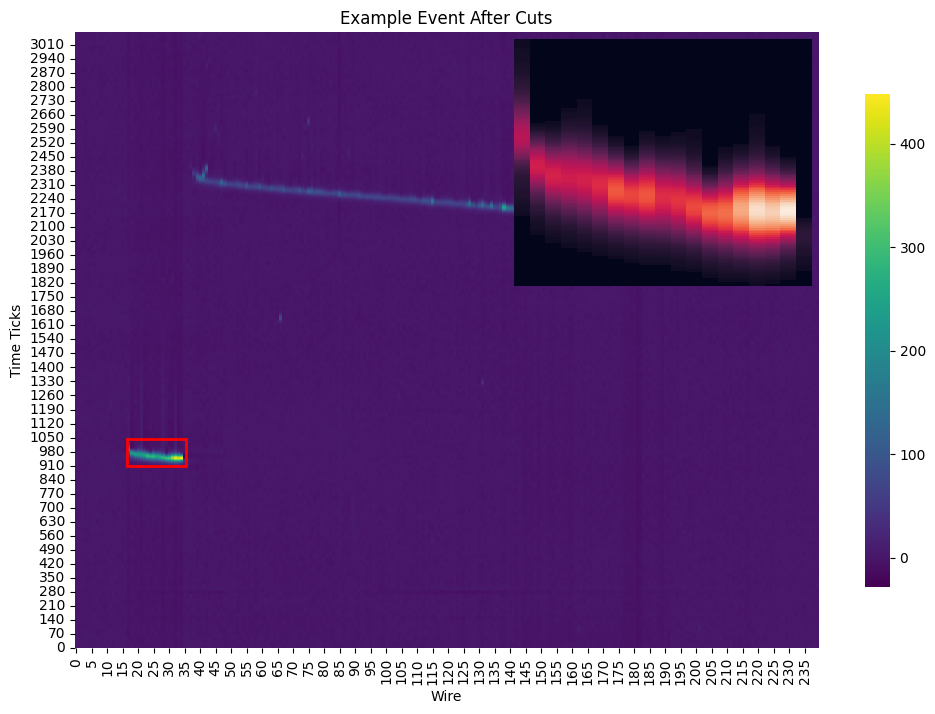

Event 10


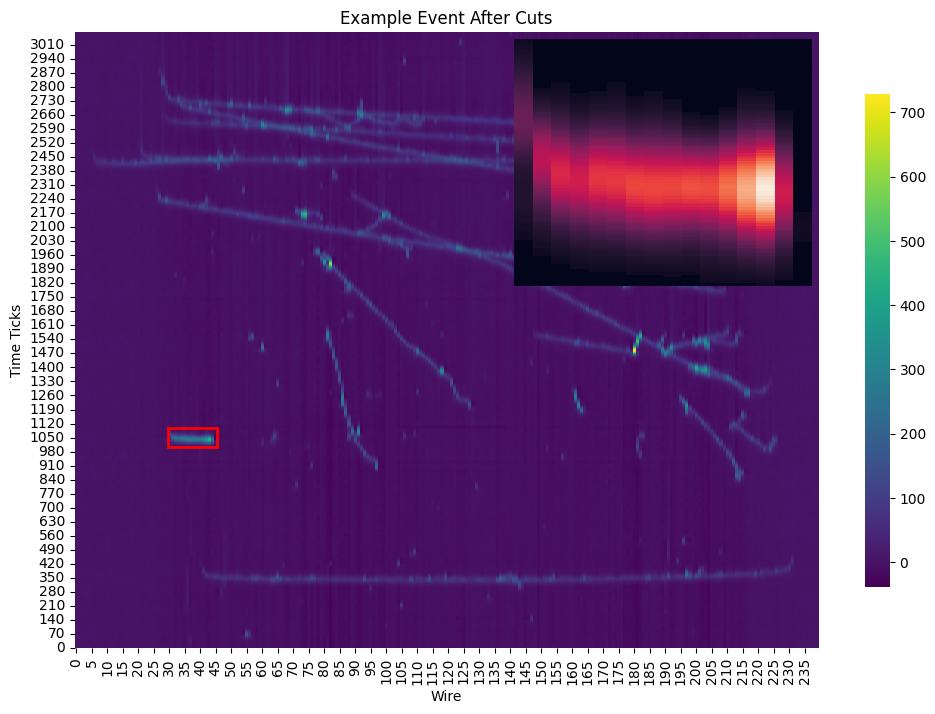

Event 11


In [30]:
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

for i in range(len(deuteron_interest)):
    
    row = deuteron_interest.iloc[i]

    event = Event(row['file_path'], row['event_index'], plot=False, threshold=15)

    fig, ax1 = plt.subplots(figsize=(12, 8))

    sns.heatmap(event.collection.T, ax=ax1, cmap='viridis', cbar_kws={'shrink': 0.8})
    ax1.invert_yaxis()

    start_wire = row['bbox_min_row'] 
    start_time = row['bbox_min_col']
    width = row['height']
    height = row['width']
    
    rect = Rectangle((start_wire, start_time), 
                     width, height, 
                     linewidth=2, 
                     edgecolor='red', 
                     facecolor='none')
    ax1.add_patch(rect)
    ax1.set_title(f'Example Event After Cuts')
    plt.ylabel('Time Ticks')
    plt.xlabel('Wire')

    ax2 = inset_axes(ax1, width="40%", height="40%", loc='upper right')
    
    sns.heatmap(row['image_intensity'].T, ax=ax2, cbar=False)
    plt.xticks([])
    plt.yticks([])
    ax2.invert_yaxis()
    # ax2.set_title('Cluster', fontsize=10)

    
    plt.show()
    print(f"Event {i}")

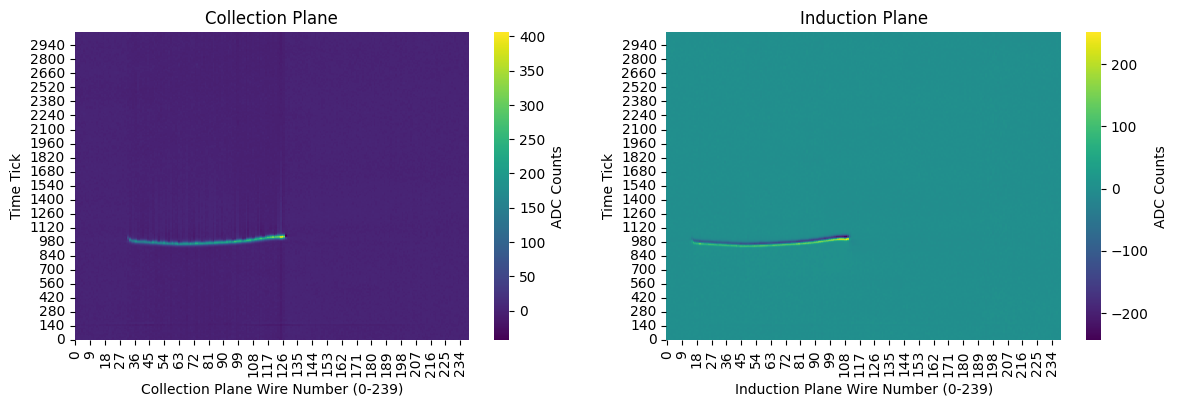

In [ ]:
event = Event(deuteron_interest.iloc[16]['file_path'], threshold=15)

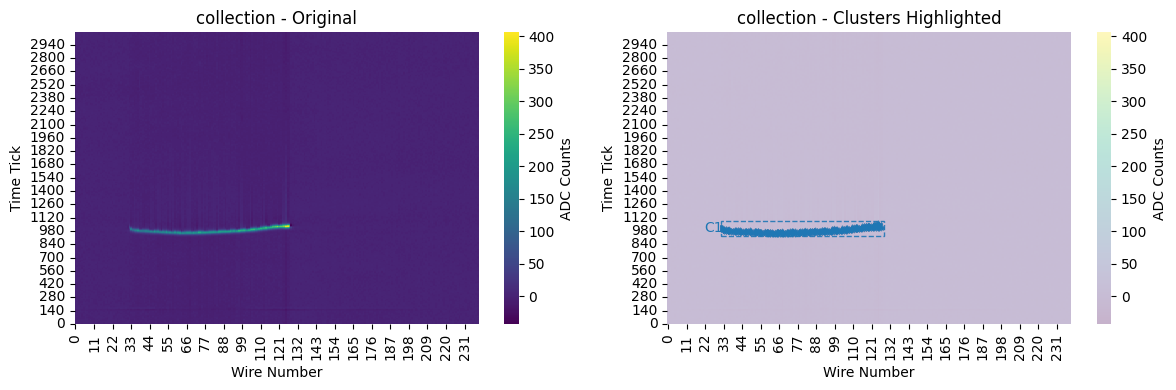

In [145]:
event.visualiseclusters(event.collection, regions=event.connectedcr, plane_name='collection', mode='highlight')